In [3]:
import numpy as np
import time
import gc
import metadevol_distance as calc_distance
from alive_progress import alive_bar

def cluster_by_centroids(argv):
    read_counts = argv[0]
    Rc_reads = argv[1]
    contig_length = argv[2]
    total_contigs = argv[3]
    dirichlet_prior = argv[4]
    dirichlet_prior_persamples = argv[5]
    kmer_counts = argv[6]
    Rc_kmers = argv[7]
    dirichlet_prior_kmers = argv[8]
    dirichlet_prior_perkmers = argv[9].flatten()
    d0 = argv[10]
    d1 = argv[11]
    tmp_dir = argv[13]
    members = []
    cluster_curr = 0
    cluster_assigned = np.zeros(total_contigs, dtype=int) - 1
    dist_to_assigned = np.zeros(total_contigs, dtype=float) + d0
    
    cluster_centroids_read = []
    cluster_centroids_kmer = []
    
    print(cluster_assigned.shape[0], "contigs are being clustered")
    neighbors = np.empty((total_contigs, 0)).tolist()
    s = time.time()
    iterate_ind = np.argsort(Rc_reads)[::-1]
    print("entering iterative distance_calculation", flush=True)
    clustercentroids_list = []

    with alive_bar(total_contigs, title='contigs processed', spinner=False, theme='classic') as bar:
    
        for c in iterate_ind:
        
            if cluster_assigned[c] < 0 :
                distance = calc_distance.compute_dist(c, read_counts, kmer_counts, Rc_reads, Rc_kmers, dirichlet_prior, dirichlet_prior_persamples, dirichlet_prior_kmers, dirichlet_prior_perkmers)
                clustercentroids_list.append(c)

                inds = np.nonzero(distance < dist_to_assigned)[0] # " there could be empty list "
                
                if len(inds) > 0 :

                    if distance[c] > d0:
                        inds = np.append(inds, c)

                    dist_to_assigned[inds] = distance[inds]
                    cluster_assigned[inds] = cluster_curr

                    for n in np.nonzero(distance < d1)[0]:
                        neighbors[n].append(cluster_curr)

                    cluster_curr += 1
            bar()

    for k in range(cluster_curr):
        if len(np.nonzero(cluster_assigned==k)[0]) > 0:
            members.append(np.nonzero(cluster_assigned==k)[0])

    for c in np.nonzero(cluster_assigned < 0)[0]:
        cluster_assigned[c] = cluster_curr
        members.append([c])
        neighbors[c].append(cluster_curr)
        cluster_curr += 1

    np.savetxt(tmp_dir + "/cluster_assigned_bothsummed_again", cluster_assigned, fmt='%d')

    print(len(members), cluster_curr)

    cluster_length = []

    for k in members:
        if len(k) == 0:
            print("check again")
        cluster_centroids_read.append(read_counts[k].sum(axis=0))
        cluster_centroids_kmer.append(kmer_counts[k].sum(axis=0))
        cluster_length.append(sum(contig_length[k]))
    
    cluster_length = np.array(cluster_length)
    
    cluster_centroids_read = np.array(cluster_centroids_read)
    cluster_centroids_kmer = np.array(cluster_centroids_kmer)

    print(cluster_curr, len(members))

    print("Obtained {} clusters from initial clustering".format(len(members)))
    print("Initial clustering took:", time.time() - s,"seconds")

    gc.collect()

    return members, cluster_centroids_read, cluster_centroids_kmer, cluster_length


def density_based_clustering(cluster_parameters, cluster_centroids_read, cluster_centroids_kmer, cluster_length):
    
    K = cluster_centroids_read.shape[0]
    dirichlet_prior = cluster_parameters[4]
    dirichlet_prior_persamples = cluster_parameters[5]
    dirichlet_prior_kmers = cluster_parameters[8]
    dirichlet_prior_perkmers = cluster_parameters[9].flatten()
    Rc_reads = np.sum(cluster_centroids_read,axis=1)
    Rc_kmers = cluster_centroids_kmer.reshape(-1,64,4).sum(axis=2)
    density = np.zeros(K, dtype=int)
    d1 = 4.0
    nearest = np.zeros(K, dtype=int)
    separation_dist = np.zeros(K) + 1e30
    

    for k in range(K):
        distance = calc_distance.compute_connectedcomponentdist(k, cluster_centroids_read, cluster_centroids_kmer, Rc_reads, Rc_kmers, dirichlet_prior, dirichlet_prior_persamples, dirichlet_prior_kmers, dirichlet_prior_perkmers)
        inds = np.nonzero(distance < d1)[0]
        nearest[k] = k
        
        if distance[k] > d1:
            inds = np.append(inds, k)
        
        density[k] = sum(cluster_length[inds])

        if len(np.nonzero(distance >= 1e30)[0]) > 0:
            raise RuntimeError("distance is far from 1e30")
        
        for k_p in range(k):

            if distance[k_p] < separation_dist[k] and density[k_p] > density[k]:
                nearest[k] = k_p
                separation_dist[k] = distance[k_p]

            elif distance[k_p] < separation_dist[k_p] and density[k_p] < density[k]:
                nearest[k_p] = k
                separation_dist[k_p] = distance[k_p]

    
    if len(np.nonzero(separation_dist==1e30)[0]) > 0:
        print(nearest[np.nonzero(separation_dist==1e30)[0]])
        print(separation_dist[np.nonzero(separation_dist==1e30)[0]])
        breakpoint()
        
    return density, separation_dist, nearest


def obtain_clusters(density, separation_dist, nearest):

    denssep_threshold = 1000
    sep_min = 4.0

    if density.size != separation_dist.size:
        raise RuntimeError(f'density size and separation distance size doesn\'t match')
    
    cluster_centers = np.nonzero((separation_dist > sep_min) & ((density * separation_dist) > denssep_threshold))[0]
    cluster_curr = cluster_centers.size
    nearest[cluster_centers] = cluster_centers

    nearest_prev = np.zeros(nearest.size, dtype=int) - 1

    while (nearest != nearest_prev).any():
        print('yes')
        nearest_prev = nearest
        nearest = nearest[nearest[nearest[nearest[:]]]]

    components = []
    print(len(set(nearest)), "set value", cluster_curr, len(cluster_centers))

    for k in range(cluster_curr):

        if len((np.argwhere(nearest == cluster_centers[k])[0])) > 0:
            components.append(np.nonzero(nearest == cluster_centers[k])[0])

        else:
            print(k, cluster_centers[k], nearest[k], flush=True)
        
    print(len(components),len(np.concatenate(components).ravel()), " elements in components")
    return components

def merge_members_by_connnected_components(components, members):
    K = len(components)
    print(len(np.concatenate(members).ravel()), flush=True)
    print(K, len(members), flush=True)
    clusters = [[] for i in range(K)]
    numclust_incomponents = []
    for k in np.arange(K):
        numclust_incomponents.append(len(components[k]))
        for c in components[k]:
            clusters[k].extend(members[c])
            
    return clusters, numclust_incomponents
        

def cluster_by_connecting_centroids(cluster_parameters):
    print("computing cluster_by_connecting_centroids", flush=True)
    s = time.time()
    argv = cluster_parameters
    tmp_dir = argv[12]
    members, cluster_centroids_read, cluster_centroids_kmer, cluster_length = cluster_by_centroids(cluster_parameters)
    ss = time.time()
    density, separation_dist, nearest = density_based_clustering(cluster_parameters, cluster_centroids_read, cluster_centroids_kmer, cluster_length)
    print("density based clustering took", time.time() - ss, "seconds")
    components = obtain_clusters(density, separation_dist, nearest)
    print(len(separation_dist), len(nearest), len(density))
    clusters, numclust_incomponents = merge_members_by_connnected_components(components, members)
    print("count_by_connecting_centroids took ", time.time() - s, "seconds")
    return clusters, numclust_incomponents



In [152]:
def density_based_clustering(cluster_parameters, cluster_centroids_read, cluster_centroids_kmer, cluster_length):
    
    K = cluster_centroids_read.shape[0]
    dirichlet_prior = cluster_parameters[4]
    dirichlet_prior_persamples = cluster_parameters[5]
    dirichlet_prior_kmers = cluster_parameters[8]
    dirichlet_prior_perkmers = cluster_parameters[9].flatten()
    Rc_reads = np.sum(cluster_centroids_read,axis=1)
    Rc_kmers = cluster_centroids_kmer.reshape(-1,64,4).sum(axis=2)
    density = np.zeros(K, dtype=int)
    d1 = 2.0
    nearest = np.zeros(K, dtype=int)
    separation_dist = np.zeros(K) + 1e30
    

    for k in range(K):
        distance = calc_distance.compute_connectedcomponentdist(k, cluster_centroids_read, cluster_centroids_kmer, Rc_reads, Rc_kmers, dirichlet_prior, dirichlet_prior_persamples, dirichlet_prior_kmers, dirichlet_prior_perkmers)
       
        inds = np.nonzero(distance < d1)[0]
        nearest[k] = k
        
        if distance[k] > d1:
            inds = np.append(inds, k)
        
        density[k] = sum(cluster_length[inds])

        if len(np.nonzero(distance >= 1e30)[0]) > 0:
            raise RuntimeError("distance is far from 1e30")
        
        for k_p in range(k):

            if distance[k_p] < separation_dist[k] and density[k_p] > density[k]:
                nearest[k] = k_p
                separation_dist[k] = distance[k_p]

            elif distance[k_p] < separation_dist[k_p] and density[k_p] < density[k]:
                nearest[k_p] = k
                separation_dist[k_p] = distance[k_p]

    
    if len(np.nonzero(separation_dist==1e30)[0]) > 0:
        print(nearest[np.nonzero(separation_dist==1e30)[0]])
        print(separation_dist[np.nonzero(separation_dist==1e30)[0]])
        breakpoint()
        
    return density, separation_dist, nearest

In [135]:
# densitytest, separation_disttest, nearesttest = density_based_clustering(cluster_parameters, cluster_centroids_read, cluster_centroids_kmer, cluster_length)

In [270]:
clusters, numclust_incomponents = merge_members_by_connnected_components(components, members)

122715
784 6059


In [2]:
members, cluster_centroids_read, cluster_centroids_kmer, cluster_length = cluster_by_centroids(cluster_parameters)

NameError: name 'cluster_by_centroids' is not defined

In [273]:
with open("/big/work/metadevol/cami2_datasets/marine/pooled_assembly/all_alignment/tmp/connected_componentsfromdensity", 'w+') as file:
    for f in range(len(clusters)):
        for q in clusters[f]:
            file.write(str(q) + " " + str(f) + "\n")

In [278]:
%load_ext autoreload
%autoreload 2
import nmf_connected_components_modified as nmfm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:
np.savetxt("/big/work/metadevol/cami2_datasets/marine/pooled_assembly/all_alignment/tmp/bin_assignments_bothsummed_density", np.stack((contig_names[bins_[0]], bins_[1])).T, fmt='%s\t%d')

In [1]:
import nmf_connected_components_modified as nmfm
# bins_ = nmfm.nmf_connected_components(read_counts, contig_length, clusters, numclust_incomponents, dirichlet_prior_persamples, dirichlet_prior)


In [4]:
import optimize_parameters as opt
import numpy as np
import time
import pandas as pd
from multiprocessing.pool import Pool

def optimize_prior_fortrimers(kmer_counts, Rc_kmers, trimercountsper_nt):

    with Pool() as pool:
        awa_values = pool.starmap(opt.obtain_optimized_alphas, \
                                [(np.take(kmer_counts,[c*4, (c*4)+1, (c*4)+2, (c*4)+3], axis=1),\
                                np.take(Rc_kmers, c, axis=1), trimercountsper_nt[c]) for c in range(64)])
    awa_values = np.array(awa_values)
    alpha_values = awa_values.sum(axis=1)

    return alpha_values, awa_values

tmp_dir = '/big/work/metadevol/cami2_datasets/marine/pooled_assembly/all_alignment/tmp/'

""" clustering parameters (default) """
d0 = 1.0
d1 = d0
min_shared_contigs = 20

""" load contig read counts """
contigs = pd.read_csv(tmp_dir + 'selected_contigs', header=None, sep=' ').to_numpy()
contig_names = contigs[:,1]
contig_length = contigs[:,2].astype(int)
# contig_length = pd.read_csv(working_dir + '../../contigs_umap_hoverdata1', header=None, usecols=[3],sep=' ')
# contig_length = contig_length.to_numpy().ravel()
fractional_counts = pd.read_csv(tmp_dir + "total_readcount", header=None,sep=' ', engine="pyarrow")
read_counts = fractional_counts.pivot_table(index = 1, columns = 0, values = 2)
read_counts = read_counts.to_numpy().T
total_contigs_source = read_counts.shape[0]
long_contigs = np.nonzero(contig_length>=2500)[0]
read_counts = read_counts[long_contigs]
total_contigs, n_size = np.shape(read_counts)

""" process high read counts """
Rc_reads = read_counts.sum(axis=1)
Rn_reads = read_counts.sum(axis=0)

ss = time.time()
dirichlet_prior = opt.optimize_alpha(read_counts, Rc_reads, Rn_reads, n_size)
print('obtained alpha parameter for read counts', dirichlet_prior, 'in' ,time.time()-ss,'seconds')
ss = time.time()
dirichlet_prior_persamples  = dirichlet_prior * Rn_reads / Rn_reads.sum()

kmer_counts = pd.read_csv(tmp_dir + "kmer_counts", header=None)
kmer_counts = kmer_counts.to_numpy()
kmer_counts = kmer_counts.reshape(total_contigs_source, 256) # convert 1D array to a 2D array with {total_contigs, all 4-mers} shape  
kmer_counts = (kmer_counts / 2)

# kmer_counts = kmer_counts[longer_contig_inds]

print("processing kmer frequencies")

GC_fractions = pd.read_csv(tmp_dir + "GC_fractionof_contigs", header=None)
GC_fractions = GC_fractions.to_numpy()

GC_tetramer = np.array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
                        2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 1, 1, 2, 2,
                        1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1,
                        2, 2, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2,
                        2, 2, 3, 3, 2, 2, 3, 3, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 1, 1,
                        2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3,
                        2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 4, 4, 3, 3, 4, 4, 2, 2, 3, 3, 2, 2,
                        3, 3, 3, 3, 4, 4, 3, 3, 4, 4, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3,
                        1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3,
                        4, 4, 3, 3, 4, 4, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 4, 4, 3, 3, 4, 4])

""" process repeat regions """
fGC_tGC = GC_fractions ** GC_tetramer
fAT_tAT = (1 - GC_fractions) ** (4 - GC_tetramer)
ekmer_counts = (np.tile((contig_length - 3)[:, None], (1,256)) * fAT_tAT * fGC_tGC)/16
repeat_index = np.nonzero((kmer_counts / ekmer_counts)>3) # theory suggested z-score but we use ratio for detecting repeat index 
setind_zero = np.vstack((np.repeat(repeat_index[0],4),\
    np.repeat(repeat_index[1] // 4  * 4, 4) + np.tile([0, 1, 2, 3], np.shape(repeat_index[1]))))
kmer_counts[setind_zero[0],setind_zero[1]] = 0
del(ekmer_counts, GC_fractions, setind_zero, repeat_index)


""" process high kmer counts """
kmer_counts = kmer_counts[long_contigs]
# scale_down_kmer = R_max / (R_max + kmer_counts.reshape(-1,64,4).sum(axis=2))
# kmer_counts = np.multiply(kmer_counts, np.repeat(scale_down_kmer, 4, axis=1))


trimercountsper_nt = kmer_counts.reshape(-1,64,4).sum(axis=0)
Rc_kmers = kmer_counts.reshape(-1,64,4).sum(axis=2)

ss = time.time()
dirichlet_prior_kmers, dirichlet_prior_perkmers = optimize_prior_fortrimers(kmer_counts, Rc_kmers, trimercountsper_nt)
print('obtained alpha parameters for kmer counts in', time.time()-ss,'seconds')
del(trimercountsper_nt)

contig_length = contig_length[long_contigs]
contig_names = contig_names[long_contigs]

cluster_parameters = list([read_counts, Rc_reads, contig_length, total_contigs, \
                        dirichlet_prior, dirichlet_prior_persamples, kmer_counts, Rc_kmers, \
                        dirichlet_prior_kmers, dirichlet_prior_perkmers.flatten(), \
                        d0, d1, min_shared_contigs, tmp_dir])   
# clusters, numclust_incomponents = cluster_by_connecting_centroids(cluster_parameters)
# ccm.cluster_by_connecting_centroids(cluster_parameters)
# clusters, numclust_incomponents = cluster_by_connecting_centroids(cluster_parameters)


obtained alpha parameter for read counts 5.63579799687585 in 1.2706897258758545 seconds
processing kmer frequencies
obtained alpha parameters for kmer counts in 5.517370939254761 seconds


In [101]:
density1, separation_dist1, nearest1 = density_based_clustering(cluster_parameters, cluster_centroids_read, cluster_centroids_kmer, cluster_length)

[350]
[1.e+30]


In [132]:
d0 = 0.5
cluster_parameters = list([read_counts, Rc_reads, contig_length, total_contigs, \
                        dirichlet_prior, dirichlet_prior_persamples, kmer_counts, Rc_kmers, \
                        dirichlet_prior_kmers, dirichlet_prior_perkmers.flatten(), \
                        d0, d1, min_shared_contigs, tmp_dir])   
members_05, cluster_centroids_read_05, cluster_centroids_kmer_05, cluster_length_05 = cluster_by_centroids(cluster_parameters)

122715 contigs are being clustered
entering iterative distance_calculation
contigs processed [========================================] 122715/122715 [100%] in 13:27.3 (152.01/s) 
11377 11377
11377 11377
Obtained 11377 clusters from initial clustering
Initial clustering took: 809.4228265285492 seconds


In [153]:
density_052, separation_dist_052, nearest_052 = density_based_clustering(cluster_parameters, cluster_centroids_read_05, cluster_centroids_kmer_05, cluster_length_05)
# components = obtain_clusters(density, separation_dist, nearest)
# print(len(separation_dist), len(nearest), len(density))
# clusters = merge_members_by_connnected_components(components, members)


[9687]
[1.e+30]


In [17]:
density_c, separation_dist_c, nearest_c = density_based_clustering(cluster_parameters, cluster_parameters[0], cluster_parameters[6], cluster_parameters[2])

[6071]
[1.e+30]


In [122]:
density[np.nonzero(separation_dist<6)[0]]


array([ 4148248,  1972850,  3181676, ..., 22558715,  3298161, 22675873])

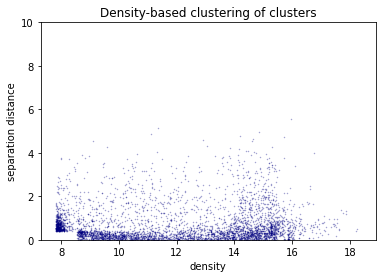

In [156]:
import matplotlib.pyplot as plt


plt.scatter(np.log(density_051),np.log(separation_dist_051), color='navy', alpha=0.4, s=0.2)
plt.ylim(0,10)
plt.xlabel('density')
plt.ylabel('separation distance')
# plt.title('Density-based clustering of contigs')
plt.title('Density-based clustering of clusters')
plt.savefig("/big/work/metadevol/cami2_datasets/marine/pooled_assembly/all_alignment/tmp/density_clusters_logd0_051.png", dpi=600,bbox_inches='tight')


(0.0, 50.0)

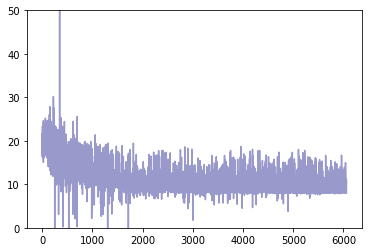

In [106]:
plt.plot(np.log(density1 * separation_dist1), color='navy', alpha=0.4)
plt.ylim(0,50)

In [112]:
np.exp(7.6)

1998.1958951041172

In [264]:
clusters, numclust_incomponents = cluster_by_connecting_centroids(cluster_parameters)

computing cluster_by_connecting_centroids
122715 contigs are being clustered
entering iterative distance_calculation
contigs processed [========================================] 122715/122715 [100%] in 4:27.4 (458.98/s) 
6059 6059
6059 6059
Obtained 6059 clusters from initial clustering
Initial clustering took: 268.5625946521759 seconds
[5834]
[1.e+30]
density based clustering took 36.84760355949402 seconds
yes
yes
yes
784 set value 784 784
784 6059  elements in components
6059 6059 6059
122715
784 6059


IndexError: list assignment index out of range

In [140]:
denssep_threshold = 1000
sep_min = 4.0

if density.size != separation_dist.size:
    raise RuntimeError(f'density size and separation distance size doesn\'t match')
nearest1 = nearest
cluster_centers = np.nonzero((separation_dist > sep_min) & ((density * separation_dist) > denssep_threshold))[0]
cluster_curr = cluster_centers.size
nearest1[cluster_centers] = cluster_centers

nearest_prev = np.zeros(nearest.size, dtype=int) - 1

while (nearest_prev != nearest).all():
    nearest_prev = nearest
    print(nearest)
    nearest = nearest[nearest[nearest[nearest[:]]]]
    print(nearest, len(nearest))

components = []

for k in range(cluster_curr):
    components.append(np.nonzero(nearest == cluster_centers[k])[0])



[5802 3672 5342 ... 5809 6057 5820]
[5802 3672 5342 ... 5809 6057 5820] 6059


In [100]:
len(np.concatenate(clusters).ravel())

98985

In [101]:
len(np.concatenate(members).ravel())

122715

(0.0, 100.0)

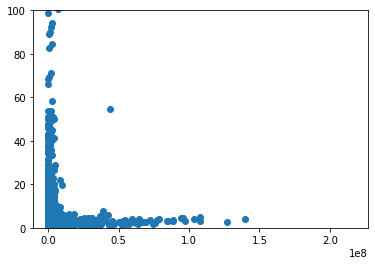

In [30]:
import matplotlib.pyplot as plt
plt.scatter(density, separation_dist)
plt.ylim(0,100)

In [62]:
cluster_assigned = np.array([-1,-1,-1,0,1,2,-1,3,5])

members=[]
for f in np.nonzero(cluster_assigned<0)[0]:

    members.append([f])
    print(f,cluster_assigned[f])
    
members

0 -1
1 -1
2 -1
6 -1


[[0], [1], [2], [6]]

In [98]:
nearest = np.array([2,3,4,5,6,7], dtype=np.int32)

nearest_prev = np.zeros(nearest.size, dtype=np.int32) - 1

while (nearest_prev != nearest).all():
    nearest_prev = nearest
    nearest = np.roll(nearest,-3)

nearest



KeyboardInterrupt: 

In [97]:
(nearest_prev != nearest).all()

True

In [51]:
nearest = np.array([2,3,4,5,0,3], dtype=np.int32)

# print(nearest)

# nearest[np.array([2,4,5])] = nearest[np.array([2,4,5])]

# print(nearest)

In [130]:
np.exp(12)

162754.79141900392

In [158]:
list=[[1,2,3],[3,5,6],[6,7,8,9,0]]

sum(list,[])

[1, 2, 3, 3, 5, 6, 6, 7, 8, 9, 0]